In [ ]:
### Phase 0: import necessary packages

!pip install -q pyomo 
!wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip" 
!unzip -o -q ipopt-linux64 

from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np



     |████████████████████████████████| 9.1 MB 5.5 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 


In [ ]:
### Phase 1: defining parameters, variables and constraints

# simulation parameters
N=20
N_sim= 150
dt=3  #(N=20) x 3 =60s sampling time

# parameters and constants
a= [0.2333, 0.242, 0.127, 0.127]
A= [50.27, 50.27, 28.27, 28.27]
g= 981
Y= [0.4, 0.4]

xs = [14, 14, 14, 21.3]
us = [43.4, 35.4]

# max and min constraints for z and v
zmin= [-6.5, -6.5, -10.7, -16.8]
zmax= [14, 14, 13.8, 6.7]

vmin = [-43.4, -35.4]
vmax = [16.6, 24.6]

alpha_1= 1 #in part A alpha was not provided
alpha_2= 792.4
P = [6.55, 6.55, 7.92, 31.7]

In [ ]:
### Phase 2: define model, optimal function and objective

def StepModel(z, v):
    z0_plus = z[0] + dt*(( -(a[0]/A[0]) * ((2*g)*(z[0] + xs[0]))**0.5 )  +  ( (a[2]/A[0]) * ((2*g)*(z[2] + xs[2]))**0.5 )  +  ( (Y[0]/A[0]) * (v[0] + us[0]) ))
    z1_plus = z[1] + dt*(( -(a[1]/A[1]) * ((2*g)*(z[1] + xs[1]))**0.5 )  +  ( (a[3]/A[1]) * ((2*g)*(z[3] + xs[3]))**0.5 )  +  ( (Y[1]/A[1]) * (v[1] + us[1]) ))
    z2_plus = z[2] + dt*(( -(a[2]/A[2]) * ((2*g)*(z[2] + xs[2]))**0.5 )  +  ( ((1-Y[1])/A[2]) * (v[1] + us[1]) ))
    z3_plus = z[3] + dt*(( -(a[3]/A[3]) * ((2*g)*(z[3] + xs[3]))**0.5 )  +  ( ((1-Y[0])/A[3]) * (v[0] + us[0]) ))
    return [z0_plus,z1_plus,z2_plus,z3_plus]



def OptimalControl(z0):
    model = ConcreteModel()  
    model.z = Var([0,1,2,3], range(N+1), domain=Reals) # z is state    
    model.v = Var([0,1], range(N), domain=Reals) # v is input

    ### Constraint definition
    # for i in [0,1,2,3]:    #state constraints upper & lower bound
    #     model.z[i,:].setlb(zmin[i])
    #     model.z[i,:].setub(zmax[i])

    for i in [0,1]:        #input constraints upper & lower bound
        model.v[i,:].setlb(vmin[i])
        model.v[i,:].setub(vmax[i])

    model.constraints = ConstraintList() #Each of the 4 z components now has 2 parameters i and t (discretized by time)
    for i in [0,1,2,3]: 
        model.constraints.add(model.z[i,0] == z0[i]) # define initial state for the [x1, x2, x3, x4] constraints 

    for t in range(N): # t has N steps from 0 to N-1
        model.constraints.add(model.z[0, t+1] == model.z[0,t] + dt*(( -(a[0]/A[0]) * ((2*g)*(model.z[0,t] + xs[0]))**0.5 )  +  ( (a[2]/A[0]) * ((2*g)*(model.z[2,t] + xs[2]))**0.5 )  +  ( (Y[0]/A[0]) * (model.v[0,t] + us[0]) )) )  
        model.constraints.add(model.z[1, t+1] == model.z[1,t] + dt*(( -(a[1]/A[1]) * ((2*g)*(model.z[1,t] + xs[1]))**0.5 )  +  ( (a[3]/A[1]) * ((2*g)*(model.z[3,t] + xs[3]))**0.5 )  +  ( (Y[1]/A[1]) * (model.v[1,t] + us[1]) )) )  
        model.constraints.add(model.z[2, t+1] == model.z[2,t] + dt*(( -(a[2]/A[2]) * ((2*g)*(model.z[2,t] + xs[2]))**0.5 )  +  ( ((1-Y[1])/A[2]) * (model.v[1,t] + us[1]) )) )  
        model.constraints.add(model.z[3, t+1] == model.z[3,t] + dt*(( -(a[3]/A[3]) * ((2*g)*(model.z[3,t] + xs[3]))**0.5 )  +  ( ((1-Y[0])/A[3]) * (model.v[0,t] + us[0]) )) )  
        model.constraints.add(sum(model.z[i,N]**2 *P[i] for i in [0,1,2,3]) <= alpha_2)  #Final/terminal constraint (from part B)

    ###                       Objective based on cost function (from part A)   
    obj = 0.5*sum(sum(alpha_1*model.z[i,t]**2 + 0.01*(model.v[i,t]**2) for t in range(N)) for i in [0,1]) 
    ###                       Objective based on both cost function and terminal cost (from part B)
    #obj = 0.5*sum(sum(alpha_2*model.v[i,t]**2 + 0.01(*model.z[i,t]**2) for t in range(N)) for i in [0,1]) + sum((model.z[i,N]**2) * P[i] for i in [0,1,2,3])
    model.objective = Objective(expr = obj, sense=minimize)
    


    #solver
    results = SolverFactory('ipopt').solve(model)
    return [model.v[0,0](), model.v[1,0]()]   #v1 at step 0 and v2 at step 0

In [ ]:
### Phase 3: Define initial conditions and call function

#initial conditions
z_init = np.zeros((4,N_sim+1))   #state contains [z1,z2,z3,z4]       
v_init = np.zeros((2,N_sim))     #input consists of [v1,v2]
z_init[:,0] = [-6,-4,-6,-1]        #initial state

#call the function
for t in range(N_sim):
    v_init[:,t] = OptimalControl(z_init[:,t]) #generate v-initial by passing z initial into optimization function
    z_init[:,t+1] = StepModel(z_init[:,t], v_init[:,t]) #generate future states using current state and inputs

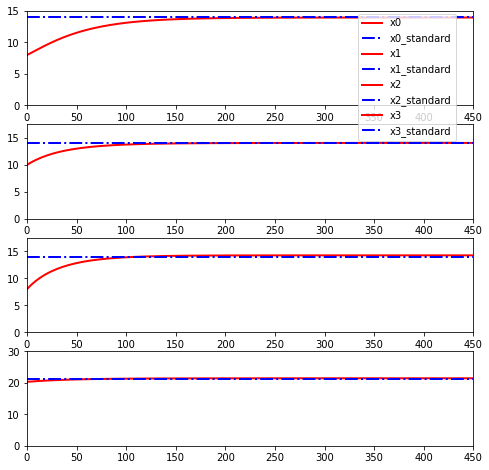

In [ ]:
###Phase 4: Plot results
#convert z values that are output into x values using: x = z + xs
x_arr = np.zeros((4,N_sim+1))
x_std = np.zeros((4,N_sim+1))

for i in range(N_sim+1): 
    x_std[0,i] = xs[0] #standard/setpoint values (xs)
    x_std[1,i] = xs[1]
    x_std[2,i] = xs[2]
    x_std[3,i] = xs[3]

    x_arr[0,i] = z_init[0,i] + xs[0] #changing values of each component (converted)
    x_arr[1,i] = z_init[1,i] + xs[1]
    x_arr[2,i] = z_init[2,i] + xs[2]
    x_arr[3,i] = z_init[3,i] + xs[3]
    

# Plot output 
# plt.figure(0)
# plt.plot(range(N_sim+1), z_init[0,i])

# plt.figure(1)
# plt.plot(range(N_sim+1), z_init[1,i])

# plt.figure(2)
# plt.plot(range(N_sim+1), z_init[2,i])

# plt.figure(3)
# plt.plot(range(N_sim+1), z_init[3,i])

fig,axis = plt.subplots(4,1, figsize=(8,8))

axis[0].set_ylim((0,15))
axis[0].set_xlim((0,450))
axis[0].plot(time,x_arr[0,:], linestyle='-', color= 'red', label='x0', linewidth=2)
axis[0].plot(time,x_std[0,:], linestyle='-.',color = 'blue', label='x0_standard', linewidth=2)

axis[1].set_ylim((0,17.5))
axis[1].set_xlim((0,450))
axis[1].plot(time,x_arr[1,:], linestyle='-',color = 'red', label='x1', linewidth=2)
axis[1].plot(time,x_std[1,:], linestyle='-.',color = 'blue',label='x1_standard', linewidth=2)

axis[2].set_ylim((0,17.5))
axis[2].set_xlim((0,450))
axis[2].plot(time,x_arr[2,:], linestyle='-',color = 'red', label='x2', linewidth=2)
axis[2].plot(time,x_std[2,:], linestyle='-.',color = 'blue',label='x2_standard', linewidth=2)

axis[3].set_ylim((0, 30))
axis[3].set_xlim((0,450))
axis[3].plot(time,x_arr[3,:], linestyle='-',color = 'red', label='x3', linewidth=2)
axis[3].plot(time,x_std[3,:], linestyle='-.',color = 'blue',label='x3_standard', linewidth=2)

fig.legend(bbox_to_anchor=(0.8,0.8))